In [218]:
"""
买卖沪深300指数，从2017-06-01 到 2018-06-20

只做多，不做空。 ->  改为可以做空和做多。
初始资金100万。
最小购买单位为1.
出现信号就全仓买入或者全部卖出，不调整金额。

每次买卖后，记录当前的时刻，现金，持仓市值，持仓数量，总资产。
"""
import myfunc
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# 调整当前notebook的宽度，运行就生效
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [331]:
# df = pd.read_csv("tmp_output_test.csv")    # 直到2018-06-20
# df_close = pd.read_csv("D:/TaoShu/后续安排2018-02-04/xtx/指数研究/hs300_1min_K_20120113_20180629_size_vol_dynamic.csv")

df = pd.read_csv("test_score_201701601_20180801.csv")
df_close = pd.read_csv("D:/TaoShu/后续安排2018-02-04/xtx/指数研究/hs300_1min_K_20120113_20180801_size_vol_dynamic.csv")

In [332]:
def get_action(ma_side, pred_prob):
    # NOACT 表示不进行任何操作，模型B不信任模型A的结果，此时既不正向操作，也不反向操作
    if (ma_side == 1 and pred_prob > 0.5):
        action = "LONG"
    elif (ma_side == -1 and pred_prob > 0.5):
        action = "SHORT"
    else:
        action = "NOACT"
    return action

df["action"] = df.apply(lambda row: get_action(row["ma_side"], row["pred_prob"]), axis=1)
df.index = pd.to_datetime(df["datetime"])

In [333]:
df_close.index = pd.to_datetime(df_close["datetime"])
close_series = df_close.close

In [334]:
if True:
    #datebegin = "2017-06-01"
    datebegin = "2018-07-01"
    df = df[datebegin:"2018-07-31"]
    close_series = close_series[datebegin:"2018-07-31"]

In [313]:
# 计算dailyVol，以便算出每个时刻的止盈止损点
df_calendar = pd.read_csv("D:/TaoShu/后续安排2018-02-04/xtx/择时/notebook/calendar_num_days.csv")                                     # 存间隔
df_calendar.index = pd.to_datetime(df_calendar["date"])
df_date = pd.read_csv("D:/TaoShu/后续安排2018-02-04/xtx/calendar_20041230_20200101.csv")                                              # 存日历
dailyVol = myfunc.getDailyVol_agu(df_close["2017-03-01":].close, span0=100, num_days=1, df_calendar=df_calendar)                      # series

标的交易有休息日的情况。


100%|██████████████████████████████████████████████████████████████████████████| 31970/31970 [00:20<00:00, 1548.95it/s]


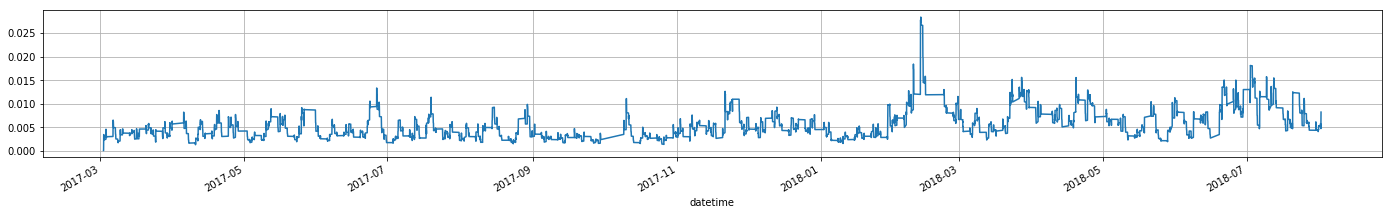

In [314]:
dailyVol["2017-03-01":].plot(figsize=(24, 3), grid=True)

In [335]:
"""
计算df的每个时间戳对应的时间边界，并将结果作为新的一列，df_calendar里，date是第t交易日，date_n5是第t+5交易日；再加3列，波动率以及止盈止损点

对于做多的情况，profit_taken是止盈点，stop_loss是止损点。
对于做空的情况，profit_taken是止损点，stop_loss是止盈点。
"""
pt = 5
sl = 10
df["vertical_barrier"] = df.apply(lambda row: df_calendar[df_calendar["date"]==row["date"]]["date_n5"].values[0] + " " + row["datetime"][-8:], axis=1)
df["profit_taken"] = df.apply(lambda row: (1 + pt * row["dailyVol"]) * close_series[row["datetime"]], axis=1 )
df["stop_loss"] = df.apply(lambda row: (1 - sl * row["dailyVol"]) * close_series[row["datetime"]], axis=1 )
# 把df 和 close_series 拼成一个dataframe
df_all = pd.merge(left=pd.DataFrame(close_series), right=df, left_index=True, right_index=True, how="left")
df_all["datetime"] = df_all.index
df_all = df_all.fillna(value=dict(action="ZHANWEI"))

In [316]:
df[df["datetime"]=="2017-06-01 10:30:00"]["vertical_barrier"].values[0]

'2017-06-08 10:30:00'

In [317]:
#np.isnan(df_all["action"].values[0])
df_all

,close,boll,boll_down,boll_up,ma_long,ma_short,macd,macd_dea,macd_dif,dailyVol,...,pred_prob,datetime,date,year_wk,dayofwk,ma_side,action,vertical_barrier,profit_taken,stop_loss
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-01 09:32:00,3487.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:32:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:34:00,3486.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:34:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:36:00,3478.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:36:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:38:00,3490.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:38:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:40:00,3491.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:40:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:42:00,3492.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:42:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:44:00,3491.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:44:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:47:00,3489.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:47:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN
2017-06-01 09:49:00,3493.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2017-06-01 09:49:00,NaN,NaN,NaN,NaN,ZHANWEI,NaN,NaN,NaN


In [324]:
action_close = "CLOSE"     # 表示平仓
def backtest(df_res, df, model_used, ptsl=True, use_score=True, onlyLong=False, onlyShort=False):
    # df_res 是结果，df是信号，信号里包含整个close序列，有些时刻没有信号，model_used是使用哪个模型的结果，onlyLong表示只做多.
    if model_used == "meta-labeling":
        print("使用meta-labeling信号预测涨跌。")
    elif model_used == "primary":
        print("使用primary model的信号预测涨跌。")

    for index, row in df.iterrows():
        # index: TimeStamp
        if model_used == "meta-labeling":
            action = row["action"]
        elif model_used == "primary":
            if row["ma_side"] == 1:
                action = "LONG"
            elif row["ma_side"] == -1:
                action = "SHORT"
            else:
                action = 'ZHANWEI'
        else:
            print("不支持的模型，退出。")
        if action == "ZHANWEI":
            if not ptsl:
                # 不加止盈止损
                continue
            # 检查action 是否是ZHANWEI，如果是，则判断是否到达止盈止损点或者竖直边界，进行平仓
            profit_taken = df_res.tail(1)["profit_taken"].values[0]
            stop_loss = df_res.tail(1)["stop_loss"].values[0]
            vertical_barrier = df_res.tail(1)["vertical_barrier"].values[0]
            curr_price = close_series[row["datetime"]]
            count = df_res.tail(1)["count"].values[0]
            if count > 0:
                # 做多的时候的止盈止损
                #print("%s 检查做多是否平仓。\t%s\t%s" %(row["datetime"], index, vertical_barrier))
                if curr_price >= profit_taken:
                    cash = cash + curr_price * df_res.tail(1)["count"].values[0]
                    print("%s\t%s\t做多止盈\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                elif curr_price <= stop_loss:
                    cash = cash + curr_price * df_res.tail(1)["count"].values[0]
                    print("%s\t%s\t做多止损\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                elif index >= pd.to_datetime(vertical_barrier):
                    cash = cash + curr_price * df_res.tail(1)["count"].values[0]
                    print("%s\t%s\t持仓时间已满5个交易日，平仓\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                else:
                    # 没有信号，进行检查时
                    pass
            elif count < 0:
                # 做空的时候的止盈止损点 是 做多的颠倒之后的
                #print("%s 检查做空是否平仓。\t%s\t%s" %(row["datetime"], index, vertical_barrier))
                profit_taken, stop_loss = stop_loss, profit_taken
                debt = df_res.tail(1)["debt"].values[0]
                if curr_price <= profit_taken:
                    cash = cash + debt 
                    debt = 0
                    cash = cash + count * curr_price
                    print("%s\t%s\t做空止盈\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                elif curr_price >= stop_loss:
                    cash = cash + debt 
                    debt = 0
                    cash = cash + count * curr_price
                    print("%s\t%s\t做空止损\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                elif index >= pd.to_datetime(vertical_barrier):
                    cash = cash + debt 
                    debt = 0
                    cash = cash + count * curr_price
                    print("%s\t%s\t持仓时间已满5个交易日，平仓\t%.2f\t%.2f"  %(action, row["datetime"], curr_price, cash))
                    df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[0], count=[0], total_mv=[cash], action=[action_close], curr_price=[curr_price], debt=[0], 
                                                                 daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
            else:
                # 当前没有持仓，不需要做判断
                pass
        elif action == "LONG":
            if onlyShort:
                continue    # 【只做空，不做多时，产生做多信号不进行操作】
            count = df_res.tail(1)["count"].values[0]
            curr_price = close_series[row["datetime"]]
            cash = df_res.tail(1)["cash"].values[0]
            debt = df_res.tail(1)["debt"].values[0]
            if use_score == True:
                score = row["pred_prob"]
                position_ptg = 2.0 * score - 0.5
                if position_ptg > 1:
                    position_ptg = 1.0
            else:
                position_ptg = 1.0
            if count > 0:
                print("%s\t%s, 已经多头，无法继续做多。" %(action, row["datetime"]))
            elif count == 0:
                # 开仓做多，当前无持仓
                #print("%s\t%s\t%d\t%f\t%f\t%d" %("before", row["datetime"], count, curr_price, cash, debt))
                count = int(position_ptg*cash/curr_price)
                cash = round(cash - count * curr_price, 2)
                mv = count * curr_price
                total_mv = cash + mv + debt
                df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[mv], count=[count], total_mv=[total_mv], action=[action], curr_price=[curr_price], debt=[debt],
                                                             daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                print("%s\t%s\t%d\t%f\t%f\t%d\t%.2f%%" %(action, row["datetime"], count, curr_price, cash, debt, 100*position_ptg))
            elif count < 0:
                # 将做空的仓位进行平仓，然后开仓做多【两个操作都做】
                #print("%s\t%s\t%d\t%f\t%f\t%d" %("before", row["datetime"], count, curr_price, cash, debt))
                cash = cash + debt  # 先平仓
                debt = 0
                cash = cash + count * curr_price
                count = int(position_ptg*cash/curr_price)      # 再开仓
                cash = cash - count * curr_price
                mv = count * curr_price
                total_mv = cash + mv + debt
                df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[mv], count=[count], total_mv=[total_mv], action=[action], curr_price=[curr_price], debt=[debt],
                                                             daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                print("%s\t%s\t%d\t%f\t%f\t%d\t%.2f%%" %(action, row["datetime"], count, curr_price, cash, debt, 100*position_ptg))
        elif action == "SHORT":
            if onlyLong:
                continue              # 【不做空，只做多。就算做空信号产生，也不卖出.】
            curr_price = close_series[row["datetime"]]
            cash = df_res.tail(1)["cash"].values[0]
            count = df_res.tail(1)["count"].values[0]
            if use_score == True:
                score = row["pred_prob"]
                position_ptg = 2.0 * score - 0.5
                if position_ptg > 1:
                    position_ptg = 1.0
            else:
                position_ptg = 1.0
            if count == 0:
                # 开仓做空，当前无持仓
                #print("%s\t%s\t%d\t%f\t%f\t%d" %("before", row["datetime"], count, curr_price, cash, debt))
                count = -1 * int(position_ptg*cash/curr_price)
                debt = -1 * count * curr_price
                mv = -1 * count * curr_price
                total_mv = cash + (debt - mv)
                df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[mv], count=[count], total_mv=[total_mv], action=[action], curr_price=[curr_price], debt=[debt],
                                                             daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                print("%s\t%s\t%d\t%f\t%f\t%d\t%.2f%%" %(action, row["datetime"], count, curr_price, cash, debt, 100*position_ptg))
            elif count > 0:
                # 将做多的仓位进行平仓，然后做空
                #print("%s\t%s\t%d\t%f\t%f\t%d" %("before", row["datetime"], count, curr_price, cash, 0))
                cash = round(cash + count * curr_price, 2)    # 先平仓做多的仓位
                count = -1 * int(position_ptg*cash/curr_price)             # 再开仓做空的仓位
                debt = -1 * count * curr_price
                mv = -1 * count * curr_price
                total_mv = cash + (debt - mv)
                df_res = df_res.append(pd.DataFrame(data=dict(datetime=[row["datetime"]], cash=[cash], mv=[mv], count=[count], total_mv=[total_mv], action=[action], curr_price=[curr_price], debt=[debt],
                                                             daily_vol=[row["dailyVol"]], profit_taken=[row["profit_taken"]], stop_loss=[row["stop_loss"]], vertical_barrier=[row["vertical_barrier"]])))
                print("%s\t%s\t%d\t%f\t%f\t%d\t%.2f%%" %(action, row["datetime"], count, curr_price, cash, debt, 100*position_ptg))
            elif count < 0:
                # 已经持有 做空的仓位了，不进行操作
                print("%s\t%s, 已经空头，无法继续做空。" %(action, row["datetime"]))
        elif action == "NOACT":
            # meta-labeling的结果，模型B选择不信任模型A的信号，不进行操作
            pass
    df_res.index = pd.to_datetime(df_res["datetime"])
    return df_res

In [336]:
"""
做空的时候，做空开仓，开仓的收入放到debt里，在平仓的时候获取这笔收入。debt是做空时的借入的标的卖出的获利，profit_taken，stop_loss，vertical_barrier分别是三边界。
"""
# 初始化
init_cash = 1e6
commission_rate = 0        # 先不设置手续费，万分之0.23，0.000023
df_res = pd.DataFrame(data=dict(datetime=["2017-06-01 09:30:00"], cash=[init_cash], mv=[0], count=[0], total_mv=[init_cash], action=["NOACT"], curr_price=[3487], debt=[0], 
                                daily_vol=[0.01], profit_taken=[3800], stop_loss=[3200], vertical_barrier=["2017-06-30 09:30:00"]))  
model_used = "meta-labeling"
df_res = backtest(df_res, df_all, model_used, ptsl=True, use_score=True)

使用meta-labeling信号预测涨跌。
LONG	2018-07-12 09:40:00	290	3437.020000	3264.200000	0	100.00%
LONG	2018-07-18 09:38:00, 已经多头，无法继续做多。
ZHANWEI	2018-07-19 09:40:00	持仓时间已满5个交易日，平仓	3449.57	1003639.50
LONG	2018-07-19 09:50:00	289	3461.880000	3156.180000	0	100.00%
LONG	2018-07-20 13:25:00, 已经多头，无法继续做多。
ZHANWEI	2018-07-24 09:59:00	做多止盈	3579.39	1037599.89
LONG	2018-07-30 10:02:00	211	3550.000000	288549.890000	0	72.35%
LONG	2018-07-30 10:04:00, 已经多头，无法继续做多。
LONG	2018-07-31 13:47:00, 已经多头，无法继续做多。
LONG	2018-07-31 15:00:00, 已经多头，无法继续做多。


In [338]:
df_res = df_res["2018-07-01":]

使用meta-labeling信号预测涨跌。


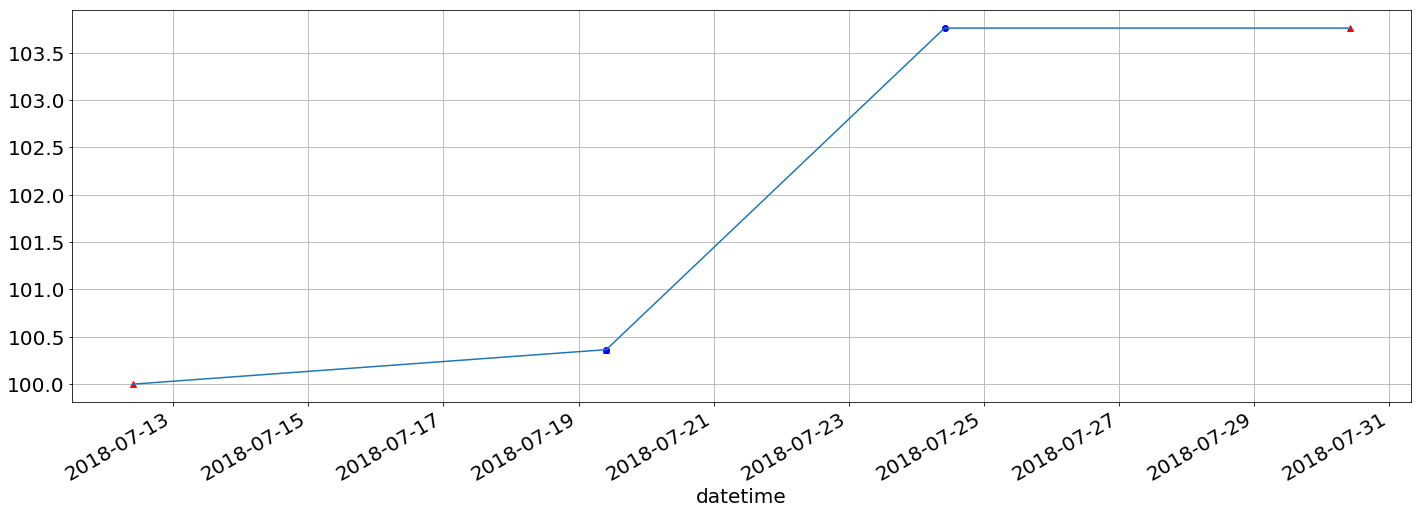

In [339]:
if model_used == "meta-labeling":
    print("使用meta-labeling信号预测涨跌。")
elif model_used == "primary":
    print("使用primary model的信号预测涨跌。")
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.tick_params(labelsize=20)
ax1.xaxis.get_label().set_fontsize(20)
df_rise = df_res[df_res["action"]=="LONG"]
#df_drop = df_res[df_res["action"]=="SHORT"]
df_pingcang = df_res[df_res["action"]=="CLOSE"]    # 强制平仓的记录
df_rise["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 8), grid=True, style="r^", ax=ax1)
#df_drop["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 8), grid=True, style="gx", ax=ax1)
df_pingcang["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 8), grid=True, style="bo", ax=ax1)
df_res["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 8), grid=True, style="-", ax=ax1)

In [328]:
df_res

,action,cash,count,curr_price,daily_vol,datetime,debt,mv,profit_taken,stop_loss,total_mv,vertical_barrier
datetime,,,,,,,,,,,,
2017-06-01 09:30:00,NoAct,1000000.00,0,3487.00,0.010000,2017-06-01 09:30:00,0,0.00,3800.000000,3200.000000,1000000.00,2017-06-30 09:30:00
2017-06-01 10:30:00,LONG,375542.39,179,3488.59,0.005179,2017-06-01 10:30:00,0,624457.61,3578.929654,3307.910692,1000000.00,2017-06-08 10:30:00
2017-06-08 10:32:00,CLOSE,1008973.27,0,3538.72,NaN,2017-06-08 10:32:00,0,0.00,NaN,NaN,1008973.27,NaN
2017-06-12 13:37:00,LONG,214712.77,222,3577.75,0.003871,2017-06-12 13:37:00,0,794260.50,3647.005237,3439.239526,1008973.27,2017-06-19 13:37:00
2017-06-19 13:40:00,CLOSE,1001689.45,0,3544.94,NaN,2017-06-19 13:40:00,0,0.00,NaN,NaN,1001689.45,NaN
2017-06-20 15:00:00,LONG,100858.13,254,3546.58,0.002943,2017-06-20 15:00:00,0,900831.32,3598.765487,3442.209027,1001689.45,2017-06-27 15:00:00
2017-06-22 09:42:00,CLOSE,1014991.43,0,3598.95,NaN,2017-06-22 09:42:00,0,0.00,NaN,NaN,1014991.43,NaN
2017-06-23 10:56:00,LONG,352252.87,184,3601.84,0.009529,2017-06-23 10:56:00,0,662738.56,3773.442795,3258.634410,1014991.43,2017-06-30 10:56:00
2017-06-30 10:56:00,CLOSE,1023547.43,0,3648.34,NaN,2017-06-30 10:56:00,0,0.00,NaN,NaN,1023547.43,NaN


In [329]:
"""
统计回测信息.
"""
num_trade_day = 259  # 总交易日
#num_trade_day = 22

baseline = df_res.tail(1)["curr_price"].values[0] / df_res.head(1)["curr_price"].values[0] - 1  # 基准收益率
return_rate = df_res.tail(1)["total_mv"].values[0] / df_res.head(1)["total_mv"].values[0] - 1   # 策略收益率
year_baseline = (1+baseline) ** (250/num_trade_day) - 1
year_return_rate = (1+return_rate) ** (250/num_trade_day) - 1
max_withdraw = 0    # 最大回撤
total_mv = df_res.total_mv.tolist()
for index, total in enumerate(total_mv):
    tmp_withdraw = max([(total - x)/total for x in total_mv[index:]])
    if tmp_withdraw > max_withdraw:
        max_withdraw = tmp_withdraw
# 收益波动率，【此处有调整，计算了每次调仓时的收益，而非计算了每日的收益率】
# 首先计算每次调仓时的收益
profit_list = list()
prev_total = total_mv[0]
for total in total_mv[1:]:
    p = (total-prev_total)/prev_total - 1
    profit_list.append(p)
    prev_total = total
profit_volatility_list = list()
for index, p in enumerate(profit_list):
    vola = sum(profit_list[:index+1]) / (index+1)
    profit_volatility_list.append(vola)
volatility = (sum([(x-y)**2 for x, y in zip(profit_list, profit_volatility_list)]) * 250 / (num_trade_day - 1) ) ** 0.5
# 夏普比率
sharp = (year_return_rate - volatility) / 0.03
# 盈利交易的比例
profit_num = 0
loss_num = 0
prev_mv = None
for index, row in df_res.iterrows():
    if prev_mv == None:
        prev_mv = row["total_mv"]
        continue
    else:
        curr_mv = row["total_mv"]
        if prev_mv == curr_mv:
            continue
        elif prev_mv < curr_mv:
            profit_num += 1
            prev_mv = curr_mv
        elif prev_mv > curr_mv:
            loss_num += 1
            prev_mv = curr_mv
profit_ptg = profit_num / (profit_num + loss_num)

In [330]:
print("收益波动率：%f\n" %(volatility, sharp, max_withdraw, baseline, return_rate, year_baseline, year_return_rate, profit_ptg))

(0.0972338701529907,
 0.6934476284020802,
 0.055721440534285176,
 0.018067106395182053,
 0.12253714000000016,
 0.01743385137088027,
 0.11803729900505311,
 0.5344827586206896)

In [207]:
init_cash = 1e6
commission_rate = 0        # 先不设置手续费，万分之0.23，0.000023
df_res = pd.DataFrame(data=dict(datetime=["2017-06-01 09:30:00"], cash=[init_cash], mv=[0], count=[0], total_mv=[init_cash], action=["NOACT"], curr_price=[3487], debt=[0], 
                                daily_vol=[0.01], profit_taken=[3800], stop_loss=[3200], vertical_barrier=["2017-06-30 09:30:00"]))  
model_used = "primary"   
df_res = backtest(df_res, df_all, model_used, ptsl=False, use_score=False)

使用primary model的信号预测涨跌。
SHORT	2017-06-01 10:13:00	-287	3477.570000	1000000.000000	998062	100.00%
LONG	2017-06-01 10:30:00	285	3488.590000	2589.110000	0	100.00%
SHORT	2017-06-02 10:12:00	-285	3487.040000	996395.510000	993806	100.00%
LONG	2017-06-02 14:15:00	285	3491.040000	309.110000	0	100.00%
SHORT	2017-06-05 09:36:00	-285	3482.960000	992952.710000	992643	100.00%
LONG	2017-06-06 10:11:00	286	3476.350000	600.460000	0	100.00%
SHORT	2017-06-06 11:11:00	-286	3472.080000	993615.340000	993014	100.00%
LONG	2017-06-06 13:38:00	285	3478.980000	132.640000	0	100.00%
LONG	2017-06-06 13:41:00, 已经多头，无法继续做多。
SHORT	2017-06-06 14:05:00	-285	3474.330000	990316.690000	990184	100.00%
LONG	2017-06-06 14:08:00	284	3475.720000	2816.060000	0	100.00%
SHORT	2017-06-12 13:19:00	-284	3572.040000	1017275.420000	1014459	100.00%
LONG	2017-06-12 13:37:00	283	3577.750000	3150.530000	0	100.00%
SHORT	2017-06-12 14:06:00	-283	3568.920000	1013154.890000	1010004	100.00%
LONG	2017-06-13 11:24:00	282	3577.170000	2058.200000	

SHORT	2017-09-21 14:07:00	-252	3841.960000	970747.370000	968173	100.00%
LONG	2017-09-21 14:22:00	251	3848.050000	3352.140000	0	100.00%
SHORT	2017-09-21 14:32:00	-251	3843.230000	968002.870000	964650	100.00%
LONG	2017-09-22 14:52:00	252	3837.920000	2179.840000	0	100.00%
SHORT	2017-09-25 09:32:00	-252	3828.360000	966926.560000	964746	100.00%
LONG	2017-09-27 09:54:00	253	3821.720000	1704.680000	0	100.00%
SHORT	2017-09-27 14:57:00	-253	3820.520000	968296.240000	966591	100.00%
LONG	2017-09-28 13:05:00	252	3823.890000	3823.350000	0	100.00%
SHORT	2017-09-28 13:41:00	-253	3820.070000	966480.990000	966477	100.00%
LONG	2017-09-28 14:00:00	252	3824.040000	1818.500000	0	100.00%
SHORT	2017-10-10 10:13:00	-252	3870.880000	977280.260000	975461	100.00%
LONG	2017-10-10 13:54:00	251	3874.850000	3692.470000	0	100.00%
SHORT	2017-10-16 13:29:00	-251	3917.960000	987100.430000	983407	100.00%
LONG	2017-10-17 13:05:00	251	3921.250000	2040.890000	0	100.00%
SHORT	2017-10-17 14:05:00	-251	3914.320000	984535.21000

SHORT	2018-01-25 14:54:00	-226	4366.210000	989232.730000	986763	100.00%
SHORT	2018-01-25 14:56:00, 已经空头，无法继续做空。
LONG	2018-01-26 09:58:00	225	4373.900000	3367.290000	0	100.00%
SHORT	2018-01-26 10:06:00	-225	4365.229900	985544.020000	982176	100.00%
LONG	2018-01-26 10:39:00	224	4376.850000	2515.097500	0	100.00%
SHORT	2018-01-29 10:29:00	-224	4379.300000	983478.300000	980963	100.00%
SHORT	2018-01-29 10:31:00, 已经空头，无法继续做空。
LONG	2018-01-31 13:14:00	234	4281.689900	3427.525800	0	100.00%
SHORT	2018-01-31 13:20:00	-234	4275.530000	1003901.550000	1000474	100.00%
LONG	2018-02-01 09:34:00	233	4285.610000	2995.700000	0	100.00%
SHORT	2018-02-01 10:08:00	-233	4265.750000	996915.450000	993919	100.00%
SHORT	2018-02-01 10:18:00, 已经空头，无法继续做空。
LONG	2018-02-02 10:43:00	236	4242.760000	980.760000	0	100.00%
SHORT	2018-02-02 13:08:00	-236	4228.720000	998958.680000	997977	100.00%
LONG	2018-02-02 14:17:00	233	4255.930000	905.430000	0	100.00%
LONG	2018-02-02 14:19:00, 已经多头，无法继续做多。
SHORT	2018-02-05 10:14:00	-233	

SHORT	2018-07-30 10:24:00, 已经空头，无法继续做空。
LONG	2018-07-31 13:47:00	373	3524.840000	2923.560000	0	100.00%
SHORT	2018-07-31 14:21:00	-373	3508.880000	1311735.800000	1308812	100.00%
SHORT	2018-07-31 14:24:00, 已经空头，无法继续做空。
LONG	2018-07-31 15:00:00	371	3517.890000	3237.880000	0	100.00%
SHORT	2018-08-01 10:58:00	-371	3510.130000	1305496.110000	1302258	100.00%


使用primary model的信号预测涨跌。


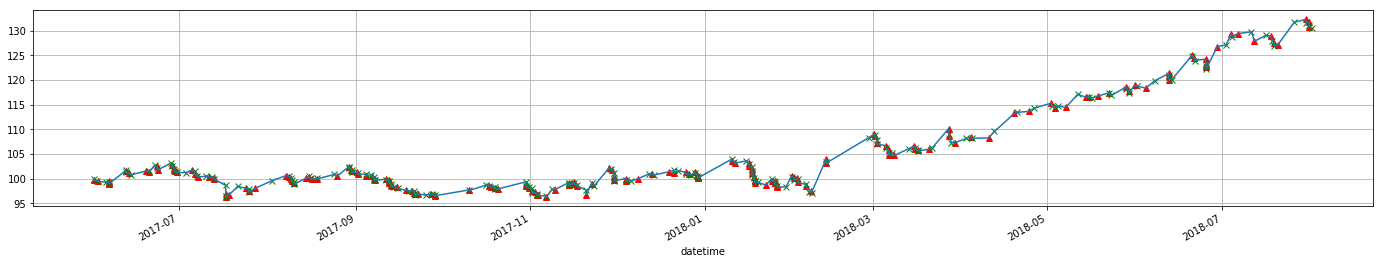

In [208]:
if model_used == "meta-labeling":
    print("使用meta-labeling信号预测涨跌。")
elif model_used == "primary":
    print("使用primary model的信号预测涨跌。")
fig, ax1 = plt.subplots(nrows=1, ncols=1)
df_rise = df_res[df_res["action"]=="LONG"]
df_drop = df_res[df_res["action"]=="SHORT"]
df_rise["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 4), grid=True, style="r^", ax=ax1)
df_drop["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 4), grid=True, style="gx", ax=ax1)
df_res["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 4), grid=True, style="-", ax=ax1)

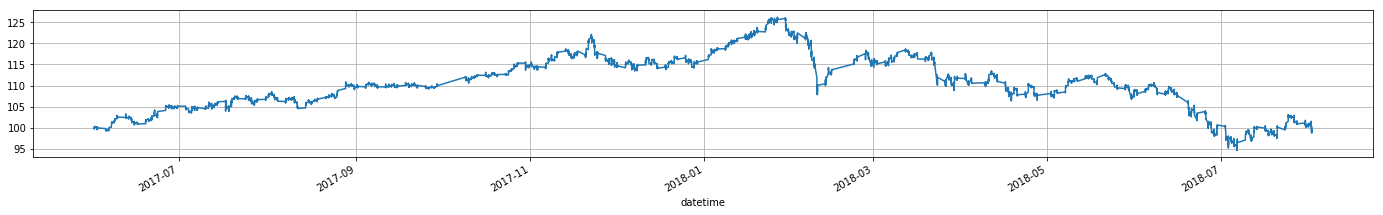

In [209]:
close_series["2017-06-01":].apply(lambda x: 100*x/3487.78).plot(figsize=(24, 3), grid=True)

In [283]:
x = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
y = [1, 1, 3]
mx = np.matrix(x)
my = np.matrix(y) 

In [280]:
mx

matrix([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])

In [285]:
my = my.reshape(-1, 1)

In [286]:
my

matrix([[1],
        [1],
        [3]])

In [287]:
mx * my

matrix([[12],
        [27],
        [42],
        [57]])

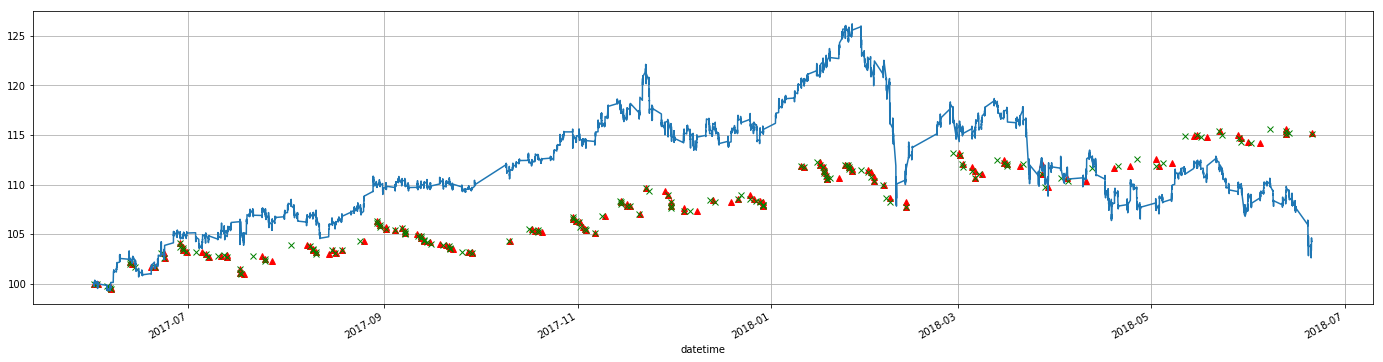

In [38]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
df_rise = df_res[df_res["action"]=="BUY"]
df_drop = df_res[df_res["action"]=="SELL"]
df_rise["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="r^", ax=ax1)
df_drop["total_mv"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="gx", ax=ax1)
close_series["2017-06-01": "2018-06-20"].apply(lambda x: 100*x/3487.78).plot(figsize=(24, 6), grid=True)

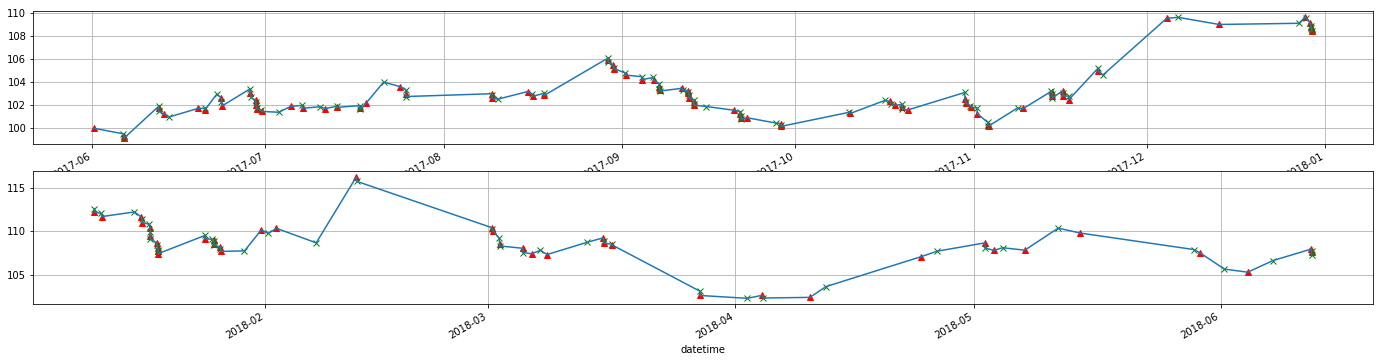

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
df_rise = df_res[df_res["action"]=="LONG"]
df_drop = df_res[df_res["action"]=="SHORT"]
df_rise["total_mv"][:"2018-01-01"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="r^", ax=ax1)
df_drop["total_mv"][:"2018-01-01"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="gx", ax=ax1)
df_res["total_mv"][:"2018-01-01"].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="-", ax=ax1)

df_rise = df_res[df_res["action"]=="LONG"]
df_drop = df_res[df_res["action"]=="SHORT"]
df_rise["total_mv"]["2018-01-01":].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="r^", ax=ax2)
df_drop["total_mv"]["2018-01-01":].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="gx", ax=ax2)
df_res["total_mv"]["2018-01-01":].apply(lambda x: 100*x/1e6).plot(figsize=(24, 6), grid=True, style="-", ax=ax2)